In [67]:
# build by swimchicken
# 23/12/23 data

# TODO 引入資料處理模組 and 深度學習模組

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, add
from tensorflow.keras.utils import plot_model

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
file_path = '/content/drive/MyDrive/深度學習-期末/fer2013.csv'

In [70]:

# TODO 引入資料並預處理

label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names = ['emotion', 'pixels', 'usage']

df = pd.read_csv(file_path, names=names, na_filter=False)
df = df.iloc[1:]

In [71]:
print(df.head())

  emotion                                             pixels     usage
1       0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
2       0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
3       2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
4       4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
5       6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


第一章圖像資料:  [[[ 70.]
  [ 80.]
  [ 82.]
  ...
  [ 52.]
  [ 43.]
  [ 41.]]

 [[ 65.]
  [ 61.]
  [ 58.]
  ...
  [ 56.]
  [ 52.]
  [ 44.]]

 [[ 50.]
  [ 43.]
  [ 54.]
  ...
  [ 49.]
  [ 56.]
  [ 47.]]

 ...

 [[ 91.]
  [ 65.]
  [ 42.]
  ...
  [ 72.]
  [ 56.]
  [ 43.]]

 [[ 77.]
  [ 82.]
  [ 79.]
  ...
  [105.]
  [ 70.]
  [ 46.]]

 [[ 77.]
  [ 72.]
  [ 84.]
  ...
  [106.]
  [109.]
  [ 82.]]]
第一章類別資料:  0


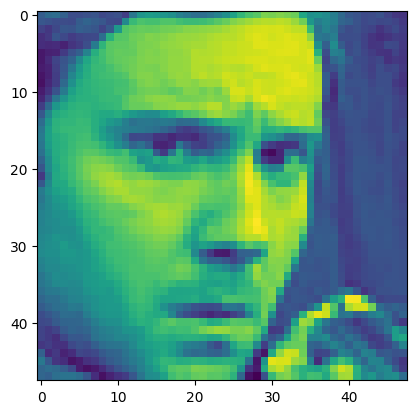

In [72]:

def get_train_data(data):
    train_data = data['pixels'].apply(lambda pixels: np.fromstring(pixels, sep=' ', dtype=np.float32))
    train_data = np.vstack(train_data).reshape(len(df), 48, 48, 1)
    return train_data


x = get_train_data(df)
y = df['emotion'].to_numpy().astype('int')

print("第一章圖像資料: ", x[0])
print("第一章類別資料: ", y[0])
plt.imshow(x[0].reshape(48, 48))
plt.show()


In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# 轉成one-hot編碼

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print(y_train.shape)
print(y_train[0])

(24044, 7)
[0. 0. 0. 0. 1. 0. 0.]


In [74]:
class TimeHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_time_start = None
        self.times = None

    def on_train_begin(self, logs=None):
        if logs is None:
            logs = {}
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.times.append(time.time() - self.epoch_time_start)


time_callback_vgg = TimeHistory()
time_callback_unet = TimeHistory()
time_callback_resid = TimeHistory()


In [75]:
# TODO 創建各模型
# vgg網路

def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2, 2), strides=(2, 2))(layer_in)
    return layer_in


# define model input
visible = Input(shape=(48, 48, 1))
# add vgg module
layer = vgg_block(visible, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 4)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_vgg = Model(inputs=visible, outputs=layer)
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_vgg = model_vgg.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test),
                            callbacks=[time_callback_vgg])

Epoch 1/10
  5/752 [..............................] - ETA: 20s - loss: 10.4761 - accuracy: 0.2062

752/752 [==============================] - 20s 24ms/step - loss: 1.8754 - accuracy: 0.2480 - val_loss: 1.8057 - val_accuracy: 0.2504
Epoch 2/10
752/752 [==============================] - 17s 23ms/step - loss: 1.7700 - accuracy: 0.2757 - val_loss: 1.7021 - val_accuracy: 0.3502
Epoch 3/10
752/752 [==============================] - 16s 22ms/step - loss: 1.5853 - accuracy: 0.3868 - val_loss: 1.5106 - val_accuracy: 0.4249
Epoch 4/10
752/752 [==============================] - 16s 22ms/step - loss: 1.4526 - accuracy: 0.4369 - val_loss: 1.4276 - val_accuracy: 0.4425
Epoch 5/10
752/752 [==============================] - 16s 22ms/step - loss: 1.3395 - accuracy: 0.4864 - val_loss: 1.3508 - val_accuracy: 0.4882
Epoch 6/10
752/752 [==============================] - 16s 22ms/step - loss: 1.2445 - accuracy: 0.5249 - val_loss: 1.2947 - val_accuracy: 0.5079
Epoch 7/10
752/752 [==============================] - 16s 22ms/step - loss: 1.1671 - accuracy: 0.5544 - val_loss: 1.2798 - val_accuracy: 0.5157
Epo

In [76]:
model_vgg.save('model_vgg.keras')

In [77]:
save_path = '/content/drive/MyDrive'
!mv model_vgg.keras /content/drive/MyDrive/

In [78]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [79]:
# define model input
visible = Input(shape=(48, 48, 1))
# add vgg module
layer = residual_module(visible, 64)
# create model

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_residual = Model(inputs=visible, outputs=layer)
model_residual.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_59 (Conv2D)          (None, 48, 48, 64)           640       ['input_9[0][0]']             
                                                                                                  
 conv2d_60 (Conv2D)          (None, 48, 48, 64)           36928     ['conv2d_59[0][0]']           
                                                                                                  
 conv2d_58 (Conv2D)          (None, 48, 48, 64)           128       ['input_9[0][0]']             
                                                                                            

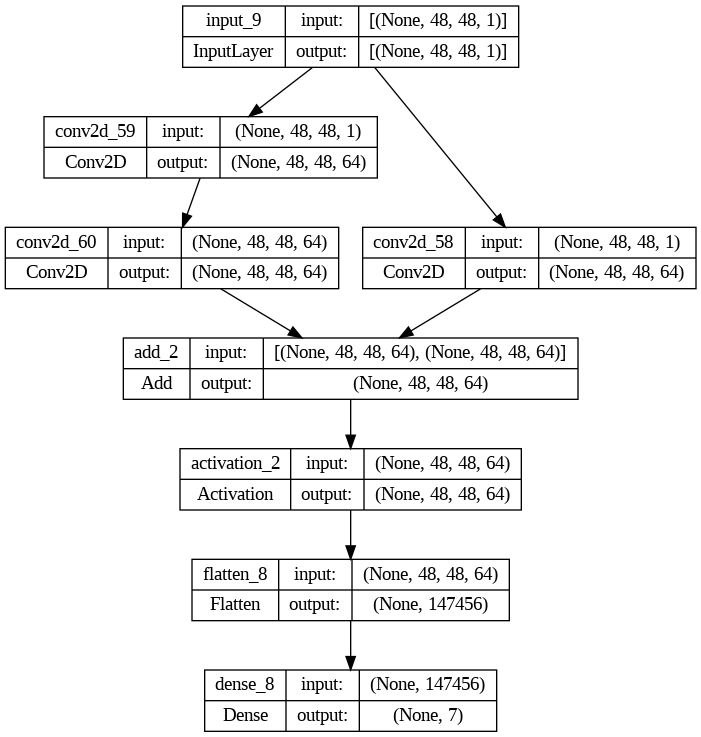

In [80]:
model_residual.summary()
plot_model(model_residual, show_shapes=True, to_file='residual_block.png')

In [81]:
history_residual = model_residual.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[time_callback_resid])

Epoch 1/10
752/752 [==============================] - 10s 12ms/step - loss: 103.8733 - accuracy: 0.2149 - val_loss: 1.8480 - val_accuracy: 0.2514
Epoch 2/10
752/752 [==============================] - 9s 12ms/step - loss: 1.8059 - accuracy: 0.2615 - val_loss: 1.8453 - val_accuracy: 0.2557
Epoch 3/10
752/752 [==============================] - 9s 11ms/step - loss: 1.7493 - accuracy: 0.2858 - val_loss: 1.8736 - val_accuracy: 0.2514
Epoch 4/10
752/752 [==============================] - 8s 11ms/step - loss: 1.6902 - accuracy: 0.3103 - val_loss: 1.9376 - val_accuracy: 0.2564
Epoch 5/10
752/752 [==============================] - 10s 13ms/step - loss: 1.6372 - accuracy: 0.3349 - val_loss: 2.1204 - val_accuracy: 0.2573
Epoch 6/10
752/752 [==============================] - 9s 12ms/step - loss: 1.5807 - accuracy: 0.3576 - val_loss: 2.2808 - val_accuracy: 0.2616
Epoch 7/10
752/752 [==============================] - 9s 12ms/step - loss: 1.5248 - accuracy: 0.3828 - val_loss: 2.3896 - val_accuracy: 0.

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 48, 48, 64)           640       ['input_10[0][0]']            
                                                                                                  
 conv2d_62 (Conv2D)          (None, 48, 48, 64)           36928     ['conv2d_61[0][0]']           
                                                                                                  
 max_pooling2d_18 (MaxPooli  (None, 24, 24, 64)           0         ['conv2d_62[0][0]']           
 ng2D)                                                                                      

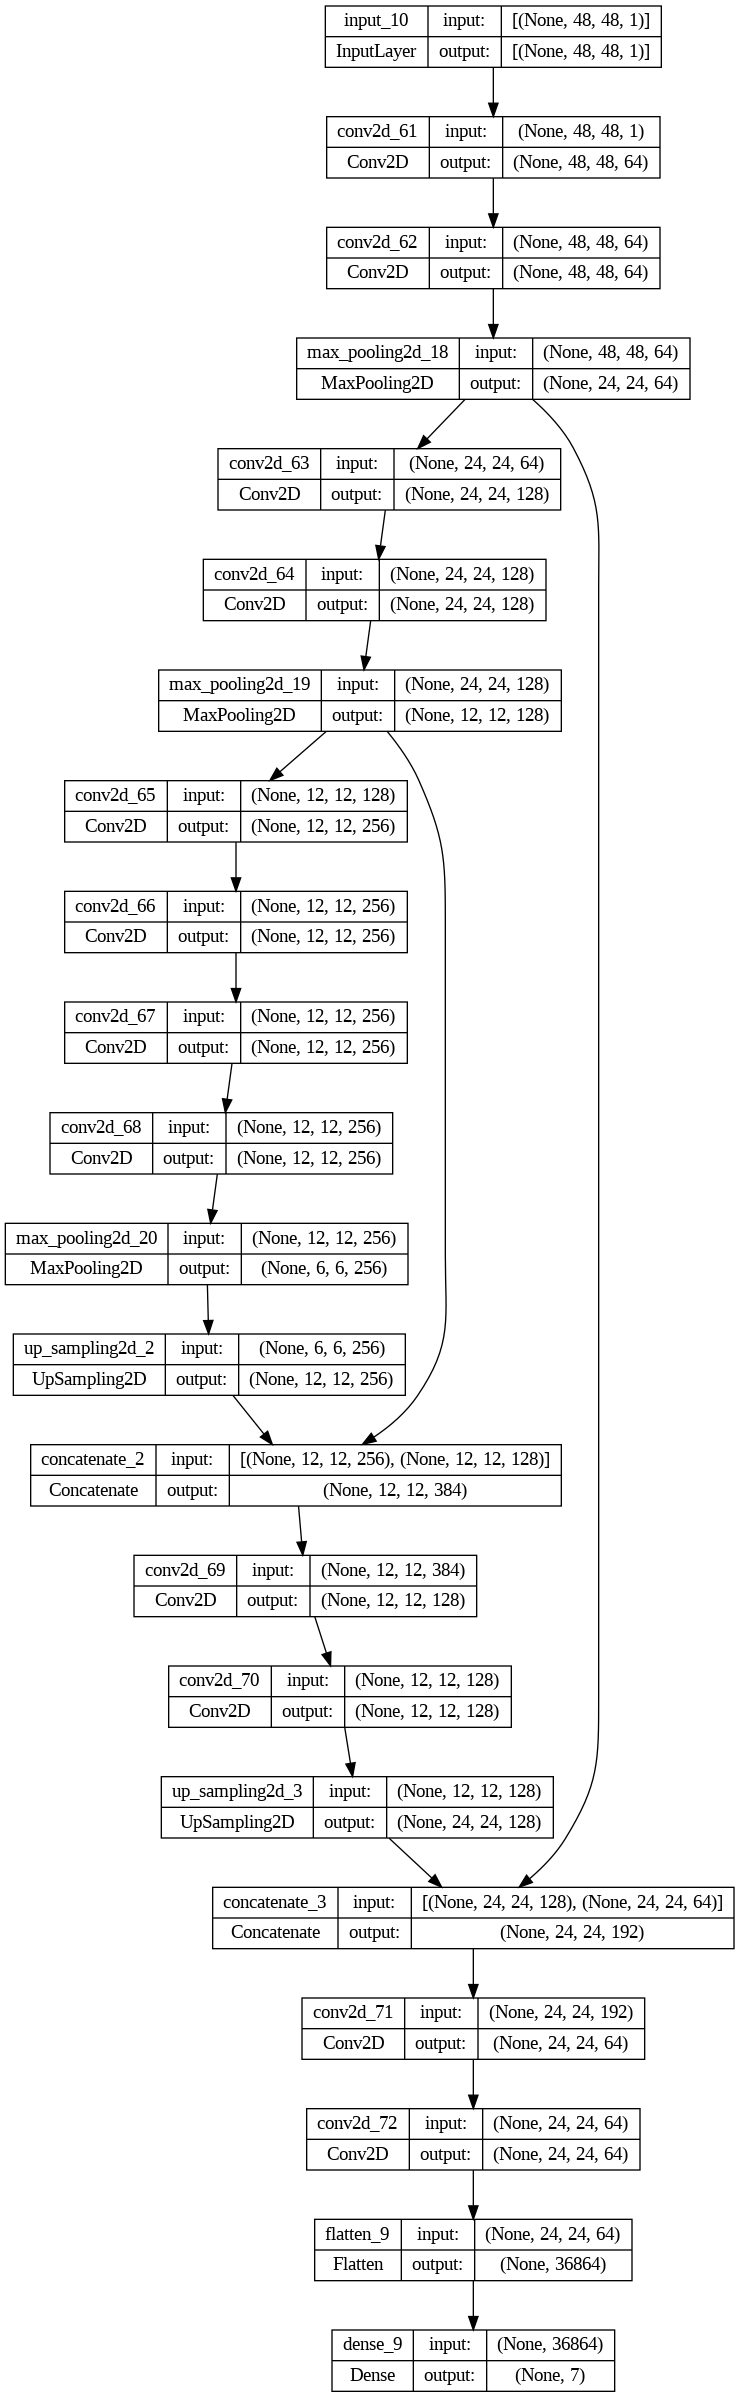

In [82]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, UpSampling2D

def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

def unet_block(layer_in, skip_in, n_filters):
    # add upsampling layer
    layer_in = UpSampling2D((2, 2))(layer_in)
    # concatenate the skip connection
    layer_in = concatenate([layer_in, skip_in], axis=-1)
    # add convolutional layers
    layer_in = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(layer_in)
    layer_in = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(layer_in)
    return layer_in


visible = Input(shape=(48, 48, 1))
vgg1 = vgg_block(visible, 64, 2)
vgg2 = vgg_block(vgg1, 128, 2)
vgg3 = vgg_block(vgg2, 256, 4)
unet1 = unet_block(vgg3, vgg2, 128)
unet2 = unet_block(unet1, vgg1, 64)
flat = Flatten()(unet2)
output = Dense(7, activation='softmax')(flat)
unet_model = Model(inputs=visible, outputs=output)

# compile the model
unet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# print model summary
unet_model.summary()

# plot the model architecture
plot_model(unet_model, show_shapes=True, to_file='vgg_unet.png')


In [83]:
unet_history = unet_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[time_callback_unet])

Epoch 1/10
752/752 [==============================] - 28s 31ms/step - loss: 1.9967 - accuracy: 0.2963 - val_loss: 1.5943 - val_accuracy: 0.3780
Epoch 2/10
752/752 [==============================] - 22s 30ms/step - loss: 1.5354 - accuracy: 0.4081 - val_loss: 1.5090 - val_accuracy: 0.4198
Epoch 3/10
752/752 [==============================] - 24s 32ms/step - loss: 1.3728 - accuracy: 0.4736 - val_loss: 1.3530 - val_accuracy: 0.4843
Epoch 4/10
752/752 [==============================] - 22s 30ms/step - loss: 1.2105 - accuracy: 0.5440 - val_loss: 1.3653 - val_accuracy: 0.4902
Epoch 5/10
752/752 [==============================] - 22s 29ms/step - loss: 1.0695 - accuracy: 0.6032 - val_loss: 1.3690 - val_accuracy: 0.4993
Epoch 6/10
752/752 [==============================] - 22s 29ms/step - loss: 0.9120 - accuracy: 0.6642 - val_loss: 1.5169 - val_accuracy: 0.4829
Epoch 7/10
752/752 [==============================] - 24s 32ms/step - loss: 0.7294 - accuracy: 0.7347 - val_loss: 1.6888 - val_accuracy:

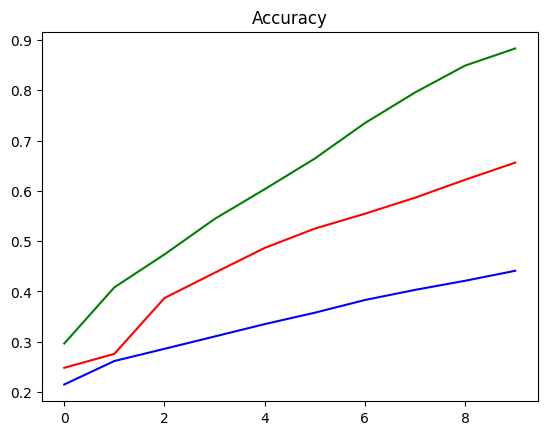

In [85]:
plt.title("Accuracy")
plt.plot(history_residual.history['accuracy'], 'b')
plt.plot(unet_history.history['accuracy'], 'g')
plt.plot(history_vgg.history['accuracy'], 'r')

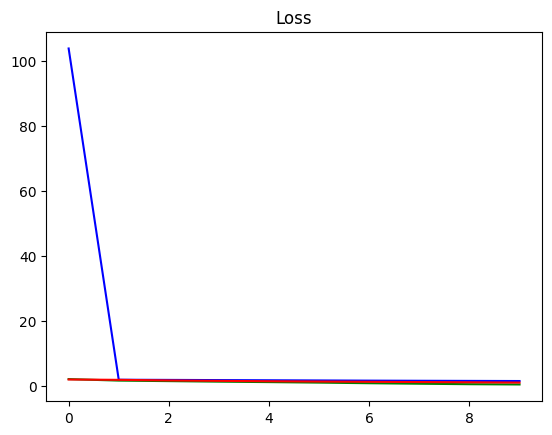

In [86]:
plt.title("Loss")
plt.plot(history_residual.history['loss'], 'b')
plt.plot(unet_history.history['loss'], 'g')
plt.plot(history_vgg.history['loss'], 'r')

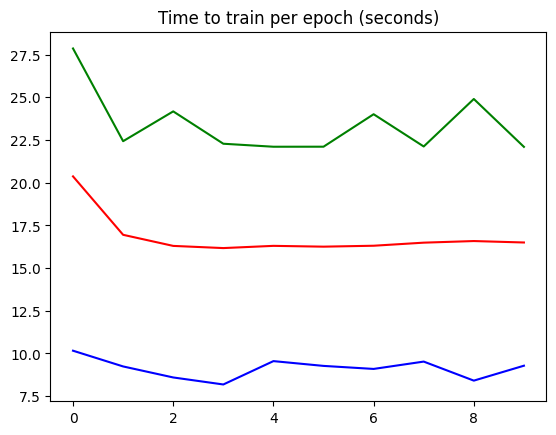

In [87]:
plt.title("Time to train per epoch (seconds)")
plt.plot(time_callback_resid.times, 'b')
plt.plot(time_callback_unet.times, 'g')
plt.plot(time_callback_vgg.times, 'r')

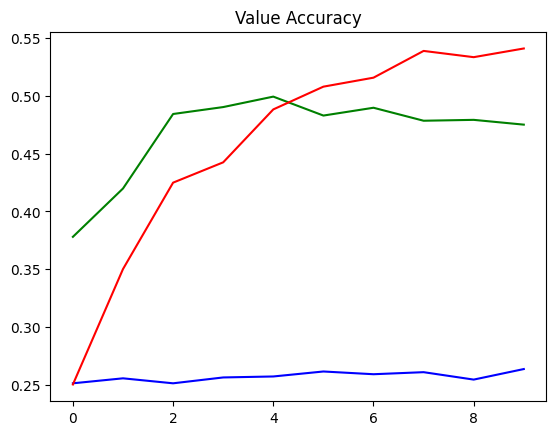

In [88]:
plt.title("Value Accuracy")
plt.plot(history_residual.history['val_accuracy'], 'b')
plt.plot(unet_history.history['val_accuracy'], 'g')
plt.plot(history_vgg.history['val_accuracy'], 'r')